In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

### Choose to use CPU or GPU

In [2]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

# CUDA support
my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use CPU for this one
my_device = torch.device("cpu")
print(f"Using device: {my_device}")

NVIDIA GeForce GTX 1650
Using device: cpu


In [3]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()

        # Input
        self.input_layer = nn.Linear(1, 20)

        # Hidden Layers
        self.hidden_layer1 = nn.Linear(20, 20)
        self.hidden_layer2 = nn.Linear(20, 20)
        self.hidden_layer3 = nn.Linear(20, 20)

        # Output
        self.output_layer = nn.Linear(20, 2)

    def forward(self, input):
        # Function for moving forward in the network
        s1 = F.tanh(self.input_layer(input))

        s2 = F.tanh(self.hidden_layer1(s1))
        s3 = F.tanh(self.hidden_layer2(s2))
        s4 = F.tanh(self.hidden_layer3(s3))

        output = self.output_layer(s4)

        return output

In [4]:
model = DNN().to(my_device)
print(model)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

DNN(
  (input_layer): Linear(in_features=1, out_features=20, bias=True)
  (hidden_layer1): Linear(in_features=20, out_features=20, bias=True)
  (hidden_layer2): Linear(in_features=20, out_features=20, bias=True)
  (hidden_layer3): Linear(in_features=20, out_features=20, bias=True)
  (output_layer): Linear(in_features=20, out_features=2, bias=True)
)
1342


# Problem
![Alt text](./images/1d_beam.png)

In [5]:
""" Parameters """

E = 7e10 # Approximately Aluminium
I = 0.1**4 / 12 # Square cross section with lenght 0.1m
Q = -20000.0 # Total load applied in Newton
L = 3.0 # Length of beam in meter

In [6]:
# Training points
x = np.random.uniform(0, L, 100)
x = np.append(x, [0, L])
x = np.sort(x)

# Applied load per meter
q = lambda x: np.full_like(x, Q)
load = q(x)

# Make Dimensionless
x_hat = x / L
q_c = np.max(np.abs(load))
q_hat = load / q_c

# Turn them into tensors
x_t = torch.tensor(x_hat, device=my_device, requires_grad=True, dtype=torch.float).view(-1, 1)
q_t = torch.tensor(q_hat, device=my_device, dtype=torch.float).view(-1, 1)


In [7]:
# Exact solution
exact = lambda x: Q / (24*E*I) * (x**4 - 4*L*x**3 + 6*L**2*x**2) # Fixed, free, constant q
u_exact = exact(x)

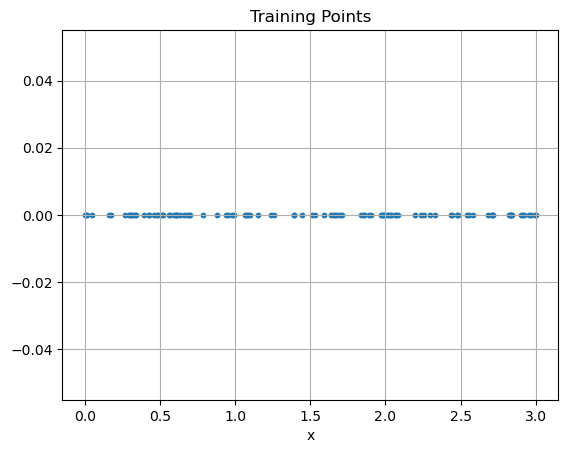

In [8]:
import matplotlib.pyplot as plt

plt.scatter(x, np.zeros_like(x), s=10)
plt.grid()
plt.xlabel("x")
plt.title("Training Points")
plt.show()

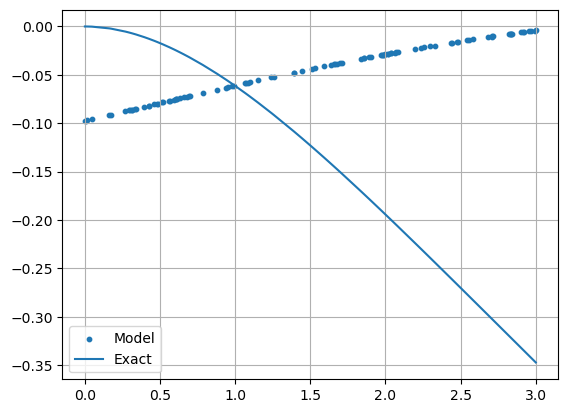

In [9]:
# Test

out = model(x_t)
u = out[:, 0:1].detach().cpu().numpy()

u_pred = (L**4 * q_c / (E*I)) * u

plt.scatter(x, u_pred, s=10, label="Model")
plt.plot(x, u_exact, label="Exact")
plt.legend()
plt.grid()

In [10]:
optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
def loss_function(x, u, m, q):

    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

    m_x = torch.autograd.grad(m, x, torch.ones_like(m), create_graph=True, retain_graph=True)[0]
    m_xx = torch.autograd.grad(m_x, x, torch.ones_like(m_x), create_graph=True)[0]

    bc_loss = u[0]**2 + u_x[0]**2
    bc_loss += m[-1]**2 + m_x[-1]**2

    pde_loss = torch.mean(torch.pow(m_xx + q, 2))
    pde_loss += torch.mean(torch.pow(u_xx + m, 2))

    return pde_loss, bc_loss

def train(epochs):
    model.train()
    track_loss = []

    for epoch in range(epochs):
        out = model(x_t)
        u = out[:, 0:1]
        m = out[:, 1:2]

        pde_loss, bc_loss = loss_function(x_t, u, m, q_t)
        loss = pde_loss + bc_loss
        track_loss.append(loss.item())

        optimizer_adam.zero_grad()
        loss.backward()
        optimizer_adam.step()

        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Total loss: {'{:e}'.format(loss.item())}")

    return track_loss


In [12]:
loss = train(1000)

Epoch: 0, Total loss: 1.012369e+00
Epoch: 100, Total loss: 2.340045e-02
Epoch: 200, Total loss: 3.893860e-03
Epoch: 300, Total loss: 4.776290e-04
Epoch: 400, Total loss: 9.901889e-05
Epoch: 500, Total loss: 5.019827e-05
Epoch: 600, Total loss: 4.220966e-05
Epoch: 700, Total loss: 3.984263e-05
Epoch: 800, Total loss: 3.811147e-05
Epoch: 900, Total loss: 3.649846e-05


Text(0, 0.5, 'Loss')

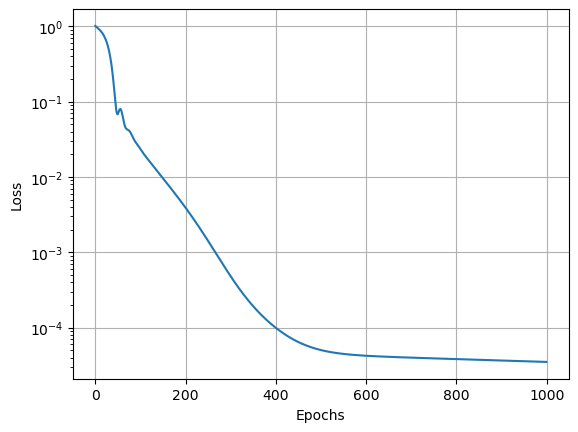

In [13]:
plt.semilogy(loss)
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [14]:
x_l = np.linspace(0, L, 10)
x_t = torch.tensor(x_l / L, device=my_device, dtype=torch.float).view(-1, 1)

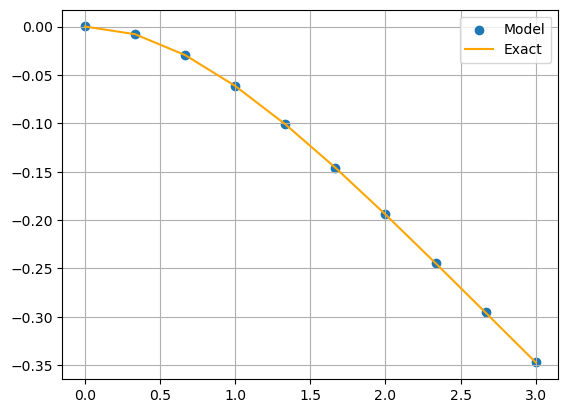

In [15]:
out = model(x_t)
u = out[:, 0:1].detach().cpu().numpy()

u_pred = (L**4 * q_c / (E*I)) * u
u_exact = exact(x_l)


plt.scatter(x_l, u_pred, label="Model")
plt.plot(x_l, u_exact, color="orange", label="Exact")
plt.legend()
plt.grid()
plt.show()